In [20]:
import quantstats as qs
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import utils as utl
import html_evaluation_portfolio as hep
import matplotlib.pyplot as plt
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from quantstats.stats import *
from quantstats._plotting.wrappers import distribution
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import df2img

## Importing and processing data

In [17]:
#set overall parameters (list opf securities and window of days on which you compute the volatility on)
list_securities = ['SSO','UBT', 'UST', 'UGL', 'DIG']
window = 30 #days

In [18]:
unique_name = ''
for i in list_securities:
    unique_name += '_' + i
    
#main
data = hep.create_dataframe(list_securities) #I can import this dataframe but it is preatty fast.
#print(data)
data_perc = hep.perc_df(data)
inv_volat_data = hep.df_inverse_volatility(data_perc, window)
data_wheighted = hep.df_wheighted(inv_volat_data)
data_earnings = hep.df_earnings(data_wheighted, data_perc)
data_earn_eq_weight = hep.df_earnings_equal_weight(data_perc)
data_earnings.dropna(inplace = True)
data_earn_eq_weight.dropna(inplace = True)
display(data_earn_eq_weight)

,SSO,UBT,UST,UGL,DIG,Tot
Date,,,,,,
2010-02-03,-0.002410,-0.005778,-0.002356,-0.002284,-0.004159,-0.016987
2010-02-04,-0.015274,0.007886,0.003905,-0.019699,-0.020407,-0.043589
2010-02-05,0.001296,0.000938,0.001643,0.001013,-0.000242,0.004647
2010-02-08,-0.004010,0.001073,-0.000486,-0.002551,-0.003720,-0.009695
2010-02-09,0.006114,-0.005102,-0.002262,0.006713,0.009606,0.015069
...,...,...,...,...,...,...
2022-03-22,0.005656,-0.006920,-0.003266,-0.003889,-0.002976,-0.011394
2022-03-23,-0.006418,0.011375,0.003182,0.006711,0.009230,0.024080
2022-03-24,0.007494,-0.004538,-0.002136,0.004071,0.000770,0.005660


## Create and export plot for the report

#### Table of returns:

In [3]:
#param
figsize=(10, 5.5)
fontname = 'Arial'
annot_size=10
square = False
cbar = False
cmap = LinearSegmentedColormap.from_list('RedGreen', ['crimson', 'gold', 'lime'])
eoy = False
compounded = True

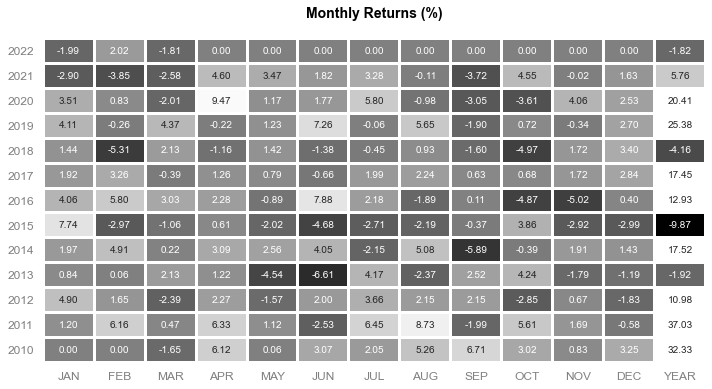

In [4]:
#crate the returns table plus the return over the year

fig, ax = plt.subplots(figsize=figsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

fig.set_facecolor('white')
ax.set_facecolor('white')

ax.set_title('Monthly Returns (%)\n', fontsize=14, y=.995,
             fontname=fontname, fontweight='bold', color='black')

returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

#print(returns.div(100).add(1).cumprod(axis = 1)) #replace(0,1).cumprod(axis=1)['DEC']
returns['YEAR'] = returns.div(100).add(1).cumprod(axis = 1)['DEC']
returns['YEAR'] = returns['YEAR'].sub(1).mul(100)

reversed_df = returns.iloc[::-1]

#display(returns)

ax = sns.heatmap(reversed_df, ax=ax, annot=True, center=0,
                annot_kws={"size": annot_size}, vmax = 10,
                fmt="0.2f", linewidths=2,
                square=square, cbar=cbar, cmap = 'gray',
                cbar_kws={'format': '%.0f%%'})

ax.tick_params(colors="#808080")
plt.xticks(rotation=0, fontsize=annot_size*1.2)
plt.yticks(rotation=0, fontsize=annot_size*1.2)
plt.subplots_adjust(hspace=0, bottom=0, top=1)
fig.tight_layout(w_pad=0, h_pad=0)
plt.savefig('./img/temp/table_montly_returns' + unique_name + '.png')
fig_table = fig 

#### Distribution plot:

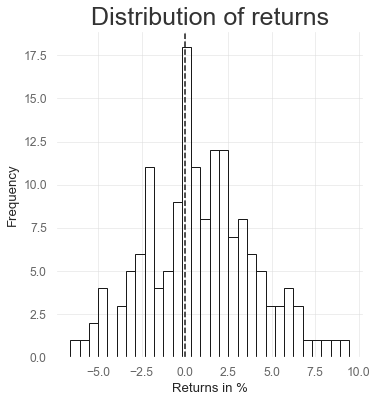

In [10]:
returns = monthly_returns(data_earnings['Tot'], eoy=eoy,compounded=compounded) * 100

series = pd.Series(dtype = 'float64')
for column in returns.columns:
    series = pd.concat([series,returns[column]])
#distribution(returns)
ax = series.plot.hist(bins = 30, edgecolor='k',fill=False)
ax.set_title('Distribution of returns', size = 25)
ax.axvline(0, color='k', linestyle='--')
ax.set_xlabel("Returns in %")
ax.set_ylabel("Frequency")
fig = ax.get_figure()
fig.set_size_inches(5.5,6)
fig.savefig('./img/temp/distribution_returns' + unique_name + '.png')
fig_distribution = fig

#### Table of statistics:

In [12]:
# create table of stats

statistics = pd.DataFrame(columns = ['index', 'value'])

statistics.loc[0] = ['Annualised return', utl.annualized_return(data_earnings['Tot'])]
statistics.loc[1] = ['Annualised volatility', utl.annualised_volatility(data_earnings['Tot'])]
statistics.loc[2] = ['Sharpe ratio', sharpe(data_earnings['Tot'])]
statistics.loc[3] = ['Sortino ratio', sortino(data_earnings['Tot'])]
statistics.loc[4] = ['Adjusted sortino', adjusted_sortino(data_earnings['Tot'])] 
statistics.loc[5] = ['Skew', skew(data_earnings['Tot'])] 
statistics.loc[6] = ['Kurtosis', data_earnings['Tot'].kurt()] 
statistics.loc[7] = ['Max drawdown', max_drawdown(data_earnings['Tot'])] 
statistics.loc[8] = ['GPR', gain_to_pain_ratio(data_earnings['Tot'])] 
statistics.loc[9] = ['Calmar ratio', calmar(data_earnings['Tot'])] 
statistics.loc[10] = ['Pay-off ratio', payoff_ratio(data_earnings['Tot'])] 

# Annualised return (At top)
# Annualizwed volatility (At top)

#export as .csv
statistics.to_csv('./data/temp/statistics_all_weather' + unique_name + '.csv')

statistics


,index,value
0,Annualised return,0.125412
1,Annualised volatility,0.116583
2,Sharpe ratio,1.076203
3,Sortino ratio,1.545507
4,Adjusted sortino,1.092838
5,Skew,-0.368049
6,Kurtosis,5.410379
7,Max drawdown,-0.192995
8,GPR,0.203479
9,Calmar ratio,0.652100


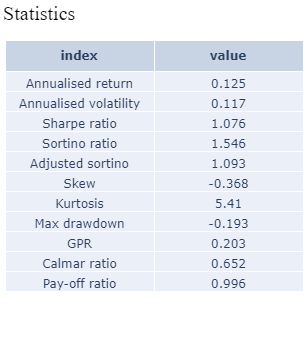

In [19]:
#transform pd. dataframe to image

fig = df2img.plot_dataframe(
    statistics.round(3),
    print_index=False,
    title=dict(
        font_color="black",
        font_family="Times New Roman",
        font_size=20,
        text="Statistics"),
    fig_size=(308, 338),

   )

df2img.save_dataframe(fig=fig, filename='./img/temp/statistics_all_weather' + unique_name + '.png')

fig_stats = fig
#statistics.to_csv('./img/temp/statistics_all_weather' + unique_name + '.csv')


#### Drawdown and underwater plots:

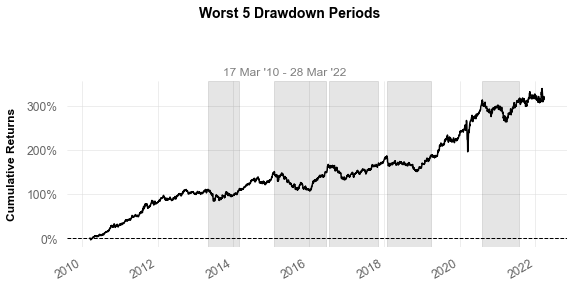

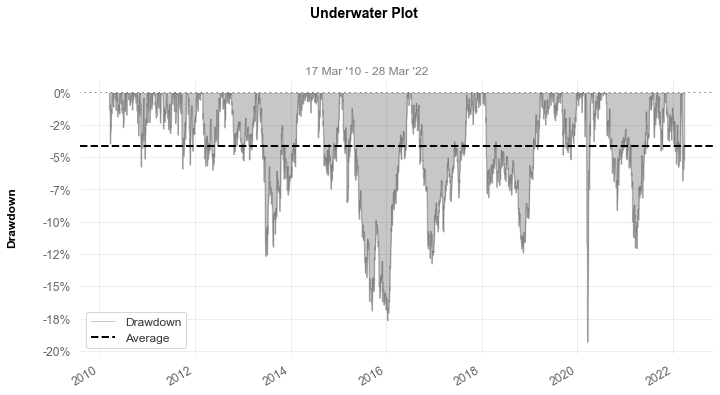

In [13]:
from quantstats._plotting.wrappers import drawdowns_periods, drawdown
drawdowns_periods(data_earnings['Tot'], grayscale = True, figsize=(8, 4), savefig =  './img/temp/drawdowns_period' + unique_name + '.png')
fig_underwater = drawdown(data_earnings['Tot'], grayscale = True, figsize=(10, 5.5), savefig =  './img/temp/under_water_plot' + unique_name + '.png')

## Combine the plots and create a figure

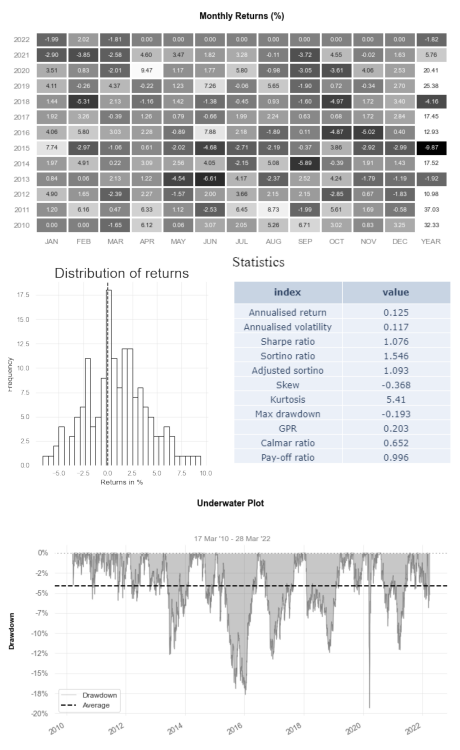

In [22]:
fig = plt.figure(figsize=(8, 13.55))

gs = gridspec.GridSpec(3, 2, wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0, :])
fig_table = plt.imread('./img/temp/table_montly_returns' + unique_name + '.png')
ax1.imshow(fig_table)
ax1.set_aspect('equal')
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.grid(False)

ax2 = plt.subplot(gs[1,:1])
fig_distribiution = plt.imread('./img/temp/distribution_returns' + unique_name + '.png')
ax2.imshow(fig_distribiution)
ax2.set_aspect('equal')
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.grid(False)

ax3 = plt.subplot(gs[1, 1:])
fig_stats = plt.imread('./img/temp/statistics_all_weather' + unique_name + '.png')
ax3.imshow(fig_stats)
ax3.set_aspect('equal')
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.grid(False)
    
ax4 = plt.subplot(gs[-1,:])
fig_underwater = plt.imread('./img/temp/under_water_plot' + unique_name + '.png')
ax4.imshow(fig_underwater)
ax4.set_aspect('equal')
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.grid(False)


plt.savefig('report' + unique_name + '.png', dpi = 1200)